<a href="https://colab.research.google.com/github/OsbornOuO/ml_virtual_currency/blob/main/06_HomeWork2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install finlab_crypto > log.txt
import finlab_crypto

finlab_crypto.setup()

ohlcv = finlab_crypto.crawler.get_all_binance('BTCUSDT', '1d')

|------------------------------
| Google Drive not connected!  
|------------------------------
|
| Please connect google drive:
Mounted at /content/drive
All caught up..!


# Exchange Transfer Volume
Exchange Transfer Volume 是使用者每天將比特幣傳到交易所，或是從交易所匯回來的總數量，下方的程式用
* tin 來表示流**進**交易所的數量，
* tout 代表流**出**交易所的數量

想像兩個使用場景：

1. 什麼時候我們會將 BTC 匯到交易所？
答案：我們想將 BTC 換成其他加密貨幣的時候
而這樣的狀況，就會導致BTC價格下跌（供給量變多）

2. 什麼時候我們會將 BTC 從交易所匯到自己的錢包中？
答案：我們想要將 BTC 長時間存起來的時候（供給量變少）

由以上兩個數據可以得知，我們希望 tin 越少越好，而 tout 越大越好，
代表比特幣價格在這幾天會有支撐甚至上漲的力道，
接下來我們就來撰寫這樣的策略吧！

首先，先得到 tin 跟 tout：

In [ ]:
from finlab_crypto.crawler import GlassnodeClient
from datetime import timezone
import pandas as pd
import numpy as np
import datetime

def get_glassnode(url, api_key, index):

    gn = GlassnodeClient()
    gn.api_key = api_key
    ret = gn.get(url)
    ret.index = ret.index + datetime.timedelta(days=1)
    ret.index = ret.index.tz_localize(timezone.utc)
    ret = ret.reindex(index, method='ffill').ffill()
    return ret.astype(float)

tin = get_glassnode('https://api.glassnode.com/v1/metrics/transactions/transfers_volume_to_exchanges_mean',
                     'c5846d6e-b7ed-4d84-9339-03e88e6db3af', index=ohlcv.index)
tout = get_glassnode('https://api.glassnode.com/v1/metrics/transactions/transfers_volume_from_exchanges_mean',
                     'c5846d6e-b7ed-4d84-9339-03e88e6db3af', index=ohlcv.index)

將 tin 跟 tout 顯示出來

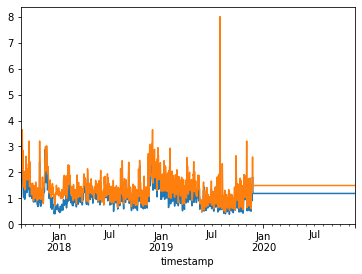

In [ ]:
# 下圖中 免費版的 API 會顯示到 2019 點底的資料
# Glassnode 的好處就是可以先研發策略，再決定要不要付費（不是業配喔XD）

製作 tout / tin 的比率：

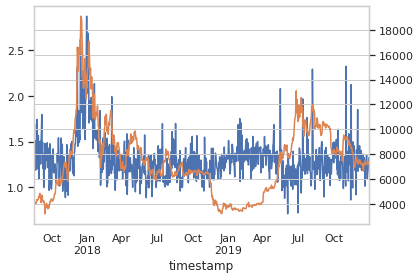

In [ ]:
tt = tout / tin

tt[:'2019'].plot()
ohlcv[:'2019'].close.plot(secondary_y=True)

研發一個測率，在 tout / tin 這個數值上升的時候，或是數值較高的時候，買入BTC，反之則賣出

In [ ]:
from finlab_crypto.indicators import trends

@finlab_crypto.Strategy(n1=200, n2=300, ratio_in=1.3)
def tcount_strategy(ohlcv):
    
    ratio = (tout / tin).reindex(ohlcv.index)
    
    n1 = tcount_strategy.n1
    n2 = tcount_strategy.n2
    
    ma1 = trends['hullma'](ratio, n1)
    ma2 = trends['sma'](ratio, n2)
    
    ######################################
    entries = (ma1 > ma2) & (ma1.shift() < ma2.shift()) & (ratio > tcount_strategy.ratio_in)
    exits = (ma1 < ma2) & (ma1.shift() > ma2.shift())
    ######################################
    
    figures = {
        'figures':{
            'net_realized': {
                'sma1': ma1,
                'sma2': ma2,
                'value': ratio,
            }
        }
    }

    return entries, exits, figures

tcount_strategy.backtest(ohlcv[:'2019'], variables={
    'n1': 4,
    'n2': 15,
    'ratio_in': 1.2,
    'sl_stop': 0.11,
}, plot=True)